In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Helper functions

These are borrowed from the `Convert.ipynb` file.

In [2]:
headings = ['Building Identifier',
            'Country',
             'City',
             'Quality / Stage of Data',
             'Construction Date',
             'Building Type',
             'Gross Floor Area']

In [3]:
df = pd.read_excel('../Dataset/dataset.xlsx',header=1,usecols='B:DWO')

In [4]:
mapper = pd.read_excel('../Conversion/Mapping material names_20210324.xlsx',header=2,usecols='B:U').replace(r'\n','', regex=True) 

In [5]:
additional_categories_map = {v:k for k,v in {
    'Continuous Footings':'0CF',
    'Foundation Walls':'0FW',
    'Spread Footings':'0SF',
    'Column Piers':'0CP',
    'Columns Supporting Floors':'CSF',
    'Floor Girders and Beams':'FGB',
    'Floor Trusses':'0FT',
    'Floor Joists':'0FJ',
    'Columns Supporting Roofs':'CSR',
    'Roof Girders and Beams':'RGB',
    'Roof Trusses':'0RT',
    'Roof Joists':'0RJ',
    'Parking Bumpers':'0PB',
    'Precast Concrete Stair Treads':'PCS',
    'Roof Curbs':'0RC',
    'Exterior Wall Construction':'EWC',
    'Composite Decking':'CPD',
    'Cast-in-Place concrete':'CIC',
    'Floor Structural Frame':'FSF',
    'Associated Metal Fabrications':'AMF',
    'Floor Construction Supplementary Components':'FCS',
    'Roof Construction Supplementary Components':'RCS',
    'Residential Elevators':'0RE',
    'Vegetated Low-Slope Roofing':'VLR',
    'Swimming Pools':'SWP',
    'Excavation Soil Anchors':'ESA',
    'Floor Trusses':'FTS',
    'Roof Window and Skylight Performance':'RWS'}.items()
}

additional_categories_map['0FT'] = 'Floor Trusses'

In [6]:
def get_material_name(l):
    try:
        split = re.split('[_\.\ ]',l) #Split up the code into its requisite parts
        result = mapper[mapper['Unnamed: 7'] == split[1]+'.'+split[2]] #Filter by Level 4 Master Format
        if len(result) == 0:
            result = mapper #If that code does not exist in the table, reset
        if len(result) == 1:
            return result['Mapping Table'].values[0] #If it maps to exactly one value, return that. We do this check after every step
        if split[3] != '000': #Check if there is an additional code, and if so filter by that
            result = result[result['Level 5\n'] == additional_categories_map[split[3]]]
            if len(result) == 1:
                return result['Mapping Table'].values[0]

        #Now filter by UniFormat.
        #Filter only by the level of UniFormat present. If the code is XX 00 00, for example, then we only have Level 1.
        if int(split[5]) == 0: 
            result = result[result['Unnamed: 12'] == f'{split[4]} 00 00']
            if len(result) == 1:
                return result['Mapping Table'].values[0]
        elif int(split[6]) == 0:
            result = result[(result['Unnamed: 14'] == f'{split[4]} {split[5]} 00') | (result['Unnamed: 16'] == f'{split[4]} {split[5]} 00')]
            if len(result) == 1:
                return result['Mapping Table'].values[0]
        else:
            result = result[result['Unnamed: 18'] == f'{split[4]} {split[5]} {split[6]}']
            if len(result) == 1:
                return result['Mapping Table'].values[0]

        #If we couldn't find it, or there is an unspecified edge case, return None. 
        if len(result) == 0:
            return None

        #If there are multiple results but they all map to the same material, return that material.
        if all(element == result['Mapping Table'].values[0] for element in result['Mapping Table'].values):
            return result['Mapping Table'].values[0]
        else:
            return None
    except:
        return None

# 1. Plot sample figures

Here we plot building material mass, and volume histograms.

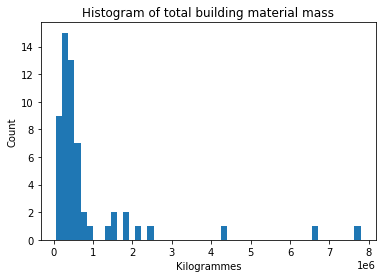

In [7]:
plt.hist(df[[c for c in df.columns if 'kg' in c]].sum(axis=1),bins=50);
plt.title('Histogram of total building material mass')
plt.xlabel('Kilogrammes')
plt.ylabel('Count');

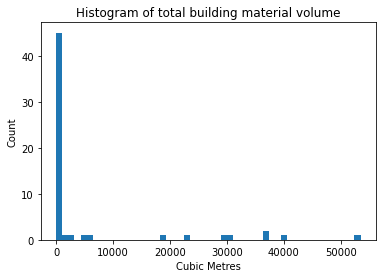

In [8]:
plt.hist(df[[c for c in df.columns if 'm3' in c]].sum(axis=1),bins=50);
plt.title('Histogram of total building material volume')
plt.xlabel('Cubic Metres')
plt.ylabel('Count');

# 2. Investigate a specific material

In this example, we use the helper function `get_material_name()` to select columns which match `steel`. Then, we calculate the average amount of steel used by floor, produce a table of values by Level 3 MasterFormat only, and calculate the average values for these by year in the dataset.

In [9]:
material = 'steel'
cols = []
for column in df.columns[7:]: #Iterate through columns that represent materials
    if get_material_name(column) == 'steel' and 'kg' in column: #If that column represents steel and is a mass value:
        cols.append(column) #Append to cols

In [10]:
steel_df = df[df.columns[1:7].to_list() + cols].fillna(0) #Select only the heading columns and the columns related to steel

In [11]:
grouping_function = lambda x: x.split('_')[0] #This function takes in a full column name, like "000_G2010.20.000_03 00 00.00_m3_1", and returns only the floor.
steel_df[cols].groupby(grouping_function,axis=1).sum().mean() 

000     9723.396120
001     5793.423194
002     5537.649070
003     3468.436813
004     1067.126362
005     1674.052936
006     1692.734624
007     2929.281477
008     2036.739192
009     1328.666273
00F    36029.486850
00R      285.259726
010     1017.699219
011     1070.051550
012      169.526162
013      199.462368
014      122.536579
015      113.883947
016      137.662193
017      127.333246
018       99.919211
019      131.161842
020      131.161842
021      467.557719
022       91.721053
023       91.610877
024       95.219123
025       94.792193
026      191.878333
027     2013.988158
028       95.205351
029       81.708860
030       81.571140
031       85.509912
032       91.542018
033      314.808702
034        9.172105
035        9.764298
036       10.439123
037       10.163684
038       10.439123
039       10.163684
040       10.439123
041       10.163684
042       10.439123
043       15.603596
044       74.740263
0P1      859.013105
0P2      569.529895
0P3     1080.440947


Now, we will aggregate to Level 3 MasterFormat codes, and display these values for the first three entries.

In [12]:
f = lambda x: re.split('[_\.\ ]',x)[1] #This function takes in a full column name and returns only the Level 3 MasterFormat code.
steel_general_df = pd.concat([steel_df[headings[1:]],steel_df[cols].groupby(f,axis=1).sum()],axis=1)

In [13]:
steel_general_df.head(3)

,Country,City,Quality / Stage of Data,Construction Date,Building Type,Gross Floor Area,A1010,A1020,A4010,A4020,...,B2010,B2050,B2070,B3010,B3060,C1030,C1090,D1010,G2010,G2060
0,CA,TOR,00IFC,2021,SND,521.18,182.801,0.0,571.6172,33.4976,...,0.0,0.0,0.0,163.5038,0.0,0.0,0.0,0.0,0.0,0.0
1,CA,TOR,00IFC,2021,SND,389.24,0.000,0.0,0.0000,27.1446,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
2,CA,TOR,00IFC,2021,SND,411.64,522.636,0.0,0.0000,15.0979,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0


We can also calculate the average for each Level 3 MasterFormat code by year of construction:

In [14]:
steel_general_df.groupby('Construction Date').mean()

,Gross Floor Area,A1010,A1020,A4010,A4020,A4040,A5010,A6010,B1010,B1020,...,B2010,B2050,B2070,B3010,B3060,C1030,C1090,D1010,G2010,G2060
Construction Date,,,,,,,,,,,,,,,,,,,,,
1913,161.080000,0.000000,0.0000,96.325400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.0000,0.000000
1917,199.930000,0.000000,0.0000,0.000000,20.818800,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.0000,0.000000
1969,373.605000,0.000000,0.0000,0.000000,98.436400,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.0000,0.000000
1988,21934.000000,134033.498513,0.0000,54829.743735,0.000000,0.000000,1235.905423,0.000000,259.573171,0.000000,...,10078.408608,0.000000,0.000,0.000000,0.000,0.000000,0.000000,668.292683,0.0000,0.000000
2007,73600.000000,0.000000,244138.1400,150141.926000,0.000000,0.000000,0.000000,0.000000,65657.800000,4498.000000,...,0.000000,0.000000,0.000,0.000000,0.000,0.000000,33330.000000,15851.600000,0.0000,0.000000
2009,73083.000000,202831.440000,0.0000,128379.999000,0.000000,0.000000,0.000000,0.000000,155524.200000,127481.444506,...,2125.780000,0.000000,177182.000,0.000000,0.000,0.000000,0.000000,13919.200000,7047.2590,0.000000
2011,11282.500000,20097.177500,22038.8750,38548.367000,0.000000,360.315000,1671.340000,0.000000,185403.503350,0.000000,...,3010.789500,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,2129.4695,3397.480000
2016,30345.000000,7123.286250,256540.0660,28069.480500,0.000000,517.236500,8969.017500,0.000000,16048.100000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.0000,0.000000
2017,39392.013333,21271.223747,210904.2151,30701.309915,0.000000,680.269612,8357.110000,0.000000,285336.159133,2272.634333,...,2267.603333,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.0000,1264.111667


We can get the average amount of steel in KG used per building type:

In [15]:
steel_general_df.groupby('Building Type').sum().mean(axis=1)

Building Type
APB    107688.992252
EDU     56688.647637
INS     10796.235456
MIX     16932.120205
OFF     97247.792600
ROW       927.811000
SMD       439.309182
SND      7954.707846
dtype: float64

In [16]:
f = lambda x: re.split('[_\.\ ]',x)[1][0:3] #From a full code, return only the use code and uncertainty code.
pd.concat([df[headings[1:]],df[cols].groupby(f,axis=1).sum()],axis=1).groupby('Building Type').mean()

,Construction Date,Gross Floor Area,A10,A40,A50,A60,B10,B20,B30,C10,D10,G20
Building Type,,,,,,,,,,,,
APB,2015.80,45113.208000,313712.342400,28267.818600,18204.180000,118.378000,61664.079600,2514.058200,1079.017200,384.216909,0.000000,758.467000
EDU,2016.50,7901.000000,137559.628021,26121.268789,0.000000,0.000000,449976.727200,0.000000,0.000000,0.000000,0.000000,0.000000
INS,1988.00,21934.000000,134033.498513,54829.743735,1235.905423,0.000000,12749.331064,10078.408608,0.000000,0.000000,668.292683,0.000000
MIX,2018.00,33975.250000,198095.110000,6271.365000,31593.110000,487.623683,97607.035000,1083.300000,0.000000,1375.850817,0.000000,0.000000
OFF,2009.00,52643.666667,162387.978333,108668.753667,299.346667,0.000000,299745.711069,60328.703333,0.000000,11110.000000,9923.600000,6033.719333
ROW,2018.00,1961.020000,0.000000,0.000000,0.000000,0.000000,16432.822000,0.000000,0.000000,0.000000,0.000000,0.000000
SMD,1994.75,236.615000,148.803500,36.032000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SND,2015.60,465.227000,956.498910,423.302155,124.672105,0.000000,259.472000,79.316650,16.422495,34.578000,0.000000,0.000000


# 3. Uncertainty by Building Type

In this section, we look at the uncertainty code associated with each column. We collect these by building type and then report the number of each value per type of building.

In [17]:
uncertainty_level = {} 
for k,v in df.iterrows():
    #Initialise empty lists for each building type as they occur
    if v['Building Type'] not in uncertainty_level.keys():
        uncertainty_level[v['Building Type']] = []
    #Append the uncertainty value for each column that is non-NaN
    for key in v[~v.isna()].keys()[7:]:
        uncertainty_level[v['Building Type']].append(key.split('_')[-1])

In [18]:
from collections import Counter

In [19]:
for k,v in uncertainty_level.items():
    uncertainty_level[k] = Counter(v) #Construct a Counter object per building type

In [20]:
uncertainty_level

{'SND': Counter({'1': 1812,
          '2': 731,
          '4': 357,
          '1.1': 1088,
          '4.1': 204,
          '2.1': 314}),
 'OFF': Counter({'1': 494, '3': 307, '1.1': 109, '3.1': 307}),
 'APB': Counter({'1': 1167, '2': 1, '3': 985, '1.1': 298, '3.1': 312}),
 'SMD': Counter({'1': 204, '2': 61, '4': 27, '1.1': 107, '2.1': 9, '4.1': 10}),
 'EDU': Counter({'1': 93, '3': 24, '1.1': 38, '3.1': 24, '2': 6}),
 'INS': Counter({'1': 90, '3': 77, '2': 1, '1.1': 90, '3.1': 77, '2.1': 1}),
 'ROW': Counter({'1': 15, '3': 5, '1.1': 14, '3.1': 5}),
 'MIX': Counter({'1': 364, '3': 276, '1.1': 287})}

Next, we aggregate columns by use code and uncertainty combined, and report the average by building type.

In [21]:
f = lambda x: re.split('[_\.\ ]',x)[1][0] + x.split('_')[-1] #From a full code, return only the use code and uncertainty code.
by_function_df = pd.concat([df[headings[1:]],df[cols].groupby(f,axis=1).sum()],axis=1)

In [22]:
by_function_df.groupby('Building Type').mean()

,Construction Date,Gross Floor Area,A1,A1.1,A2,A2.1,A3,A3.1,A4,A4.1,...,B4.1,C1,C1.1,C2,C2.1,D1,D1.1,G1,G3,G3.1
Building Type,,,,,,,,,,,,,,,,,,,,,
APB,2015.80,45113.208000,231737.663200,1985.845200,0.000000,0.00000,96188.909000,30390.301600,0.000000,0.000000,...,0.000000,192.108455,192.108455,0.000,0.000,0.000000,0.000000,225.295,533.172000,0.000
EDU,2016.50,7901.000000,0.000000,0.000000,0.000000,0.00000,74976.547506,88704.349305,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,0.000,0.000000,0.000
INS,1988.00,21934.000000,0.000000,0.000000,0.000000,0.00000,92557.312757,97541.834914,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000,0.000,334.146341,334.146341,0.000,0.000000,0.000
MIX,2018.00,33975.250000,151968.510000,0.000000,0.000000,0.00000,84478.698683,0.000000,0.000000,0.000000,...,0.000000,1375.850817,0.000000,0.000,0.000,0.000000,0.000000,0.000,0.000000,0.000
OFF,2009.00,52643.666667,0.000000,0.000000,0.000000,0.00000,127794.205833,143561.872833,0.000000,0.000000,...,0.000000,5555.000000,5555.000000,0.000,0.000,4961.800000,4961.800000,0.000,2872.053333,3161.666
ROW,2018.00,1961.020000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,0.000,0.000000,0.000
SMD,1994.75,236.615000,82.653250,82.653250,11.036450,0.00000,0.000000,0.000000,4.246275,4.246275,...,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,0.000,0.000000,0.000
SND,2015.60,465.227000,676.023563,676.023563,68.474865,43.26537,0.000000,0.000000,20.342905,20.342905,...,6.686572,0.000000,0.000000,17.289,17.289,0.000000,0.000000,0.000,0.000000,0.000


Next, we report the total amount of material falling under each uncertainty code by year of construction.

In [23]:
f = lambda x: x.split('_')[-1] #Select only the uncertainty code.
pd.concat([df[headings[1:]],df[cols].groupby(f,axis=1).sum()],axis=1).groupby('Construction Date').mean()

,Gross Floor Area,1,1.1,2,2.1,3,3.1,4,4.1
Construction Date,,,,,,,,,
1913,161.080000,48.162700,48.162700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1917,199.930000,0.000000,0.000000,20.818800,0.000000,0.000000,0.000000,0.000000,0.000000
1969,373.605000,0.000000,0.000000,98.436400,0.000000,0.000000,0.000000,0.000000,0.000000
1988,21934.000000,463.932927,463.932927,0.000000,0.000000,103273.679739,109393.634433,0.000000,0.000000
2007,73600.000000,59668.700000,59668.700000,0.000000,0.000000,276886.770000,298443.498000,0.000000,0.000000
2009,73083.000000,237053.422253,237053.422253,0.000000,0.000000,155250.235000,185134.243000,0.000000,0.000000
2011,11282.500000,93514.931675,93514.931675,0.000000,0.000000,45065.083750,49359.975750,0.000000,0.000000
2016,30345.000000,133494.550000,8024.050000,0.000000,0.000000,122269.048750,81174.024000,0.000000,0.000000
2017,39392.013333,316381.280567,142282.354567,0.000000,0.000000,126400.375837,7595.330870,0.000000,0.000000


# 4. Material Intensity

We can easily calculate material intensity by dividing columns which are measured in kilograms by the `Gross Floor Area`:

In [24]:
kilogram_columns = [d for d in df.columns if 'kg' in d]
df_mi = df[kilogram_columns].div(df['Gross Floor Area'],axis=0)

In [25]:
f = lambda x: re.split('[_\.\ ]',x)[1][0:3]
pd.concat([df[headings[1:]],df_mi[kilogram_columns].groupby(f,axis=1).sum()],axis=1)[df['Building Type'] == 'SND']

,Country,City,Quality / Stage of Data,Construction Date,Building Type,Gross Floor Area,A10,A20,A40,A50,...,A90,B10,B20,B30,C10,C20,D10,D20,F10,G20
0,CA,TOR,00IFC,2021,SND,521.18,353.958084,14.438812,323.952856,0.000000,...,0.0,54.998131,147.811220,14.393646,29.836010,16.618827,0.0,0.0,0.0,0.0
1,CA,TOR,00IFC,2021,SND,389.24,281.318698,13.374339,194.232091,0.000000,...,0.0,36.739564,133.423435,5.461939,41.974701,6.490936,0.0,0.0,0.0,0.0
2,CA,TOR,00IFC,2021,SND,411.64,465.097017,19.208236,218.629213,0.000000,...,0.0,43.752969,182.905692,3.955589,35.166432,9.149811,0.0,0.0,0.0,0.0
3,CA,TOR,00IFC,2021,SND,269.56,258.361801,6.543260,128.098456,0.000000,...,0.0,57.294905,370.711117,6.503479,36.241829,8.510443,0.0,0.0,0.0,0.0
6,CA,TOR,00IFC,2021,SND,445.99,301.393384,16.469983,179.786278,0.108904,...,0.0,63.871222,114.888632,11.934602,34.740910,12.782125,0.0,0.0,0.0,0.0
7,CA,TOR,00IFC,2021,SND,438.45,270.947699,7.767302,277.432676,0.000000,...,0.0,64.247009,255.228896,19.770004,19.607741,6.584780,0.0,0.0,0.0,0.0
8,CA,TOR,00IFC,2021,SND,714.07,276.917123,15.274836,317.786761,0.000000,...,0.0,63.916950,206.174209,19.930097,82.669534,13.127789,0.0,0.0,0.0,0.0
9,CA,TOR,00IFC,2021,SND,343.24,285.386581,16.513088,141.281528,0.000000,...,0.0,57.151395,251.349228,8.589688,44.584390,11.076655,0.0,0.0,0.0,0.0
12,CA,TOR,00IFC,2021,SND,226.89,265.332998,5.559963,136.637311,1.871224,...,0.0,57.861266,233.301466,17.701736,45.636983,6.134611,0.0,0.0,0.0,0.0
13,CA,TOR,00IFC,2021,SND,611.73,344.014507,10.923807,211.850660,0.000000,...,0.0,62.638873,186.629283,5.196340,33.144722,7.638991,0.0,0.0,0.0,0.0
